# Etude de la concentration de CO2 dans l'atmosphère depuis 1958

Importation des librairies nécessaires à l'analyse:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Importation des données

Les données sont accessible sur le site de [l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). Ils s'agit d'un suivi des teneurs en CO2 mesurées au Mauna Loa Observatory à Hawaii depuis 1958. Elles sont téléchargée en date du 02/06/2021. Si le fichier de données n'a plus de version locale, il sera téléchargé.

In [2]:
data_url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'

data_file = "C02-atmosphere.csv"
import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Les 54 premières lignes du fichiers sont une description des données et quelques indications, elle ne seront pas prise en compte lors de la création du dataFrame de l'analyse.  
La structure des données, comme indiquée dans le fichier CSV est la suivante:  

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| Year           | Année aucours de laquelle la mesure a été faite                                                                                 |
| Month          | Mois au cours duquel la mesure a été faite
                    |
| Date           | Date de la mesure au format Excel
                    |
| Date           | Date de la mesure au format ISO
                    |
| CO2 (ppm)      | Taux de CO2 en micro mole par mole (ppm)
                    |
| CO2 adjusted (ppm)| Taux de CO2 auquel on a retiré les variations saisonnières
                    |
| CO2 smoothed(ppm) | Taux de CO2 ajusté
                    |
| CO2 smoothed and adjusted (ppm) | Taux de CO2 auquel on a retiré les variations saisonnières et ajusté
                    |
| CO2 completed (ppm) | Identique à la colonne 5, les valeurs manquantes sont prises dans la colonne 7
                    |
| CO2 adjusted completed (ppm) | Identique à la colonne 6, les valeurs manquantes sont prises dans la colonne 8
                    |  
                    
 

In [4]:
raw_data = pd.read_csv(data_file, skiprows=54)
raw_data.head()

Yr   Mn      Date        Date        CO2  seasonally          fit  \
0                                                adjusted                
1                Excel                  [ppm]      [ppm]         [ppm]   
2  1958   01     21200   1958.0411     -99.99      -99.99       -99.99   
3  1958   02     21231   1958.1260     -99.99      -99.99       -99.99   
4  1958   03     21259   1958.2027     315.70      314.44       316.19   

     seasonally           CO2       seasonally  
0  adjusted fit        filled  adjusted filled  
1         [ppm]         [ppm]            [ppm]  
2        -99.99        -99.99           -99.99  
3        -99.99        -99.99           -99.99  
4        314.91        315.70           314.44

Les lignes 0 et 1 vont gêner l'analyse et ne contiennent que des indications sur les données. Nous les retirons. Les titres de colonnes contiennent des espaces qui gêne leur appel. Nous renommons donc également les colonnes:

In [5]:
data = raw_data.drop(labels=[0,1], axis=0).copy()

col_list = data.columns
data.rename(columns={col_list[0]: 'year', col_list[1]: 'month', col_list[2]: 'Date1',
                     col_list[3]: 'Date2', col_list[4]: 'CO2', col_list[5]: 'CO2 overall',
                    col_list[6]: 'C02_3', col_list[7]: 'CO2_4', col_list[8]: 'C02_5',
                    col_list[9]: 'CO2_6'}, inplace=True)
data.head()


year month     Date1       Date2        CO2 CO2 overall        C02_3  \
2  1958    01     21200   1958.0411     -99.99      -99.99       -99.99   
3  1958    02     21231   1958.1260     -99.99      -99.99       -99.99   
4  1958    03     21259   1958.2027     315.70      314.44       316.19   
5  1958    04     21290   1958.2877     317.45      315.16       317.30   
6  1958    05     21320   1958.3699     317.51      314.70       317.87   

       CO2_4        C02_5      CO2_6  
2     -99.99       -99.99     -99.99  
3     -99.99       -99.99     -99.99  
4     314.91       315.70     314.44  
5     314.99       317.45     315.16  
6     315.07       317.51     314.70

On converti les colonnes 'year' et 'month' en période que l'on défini ensuite comme index

In [6]:
def convert_month(year,month):
    return pd.Period(year = int(year), month = int(month), freq='M')

data['period'] = [convert_month(year,month) for year,month in zip(data['year'],data['month'])]
data = data.set_index('period')
data.head()

year month     Date1       Date2        CO2 CO2 overall        C02_3  \
period                                                                          
1958-01  1958    01     21200   1958.0411     -99.99      -99.99       -99.99   
1958-02  1958    02     21231   1958.1260     -99.99      -99.99       -99.99   
1958-03  1958    03     21259   1958.2027     315.70      314.44       316.19   
1958-04  1958    04     21290   1958.2877     317.45      315.16       317.30   
1958-05  1958    05     21320   1958.3699     317.51      314.70       317.87   

             CO2_4        C02_5      CO2_6  
period                                      
1958-01     -99.99       -99.99     -99.99  
1958-02     -99.99       -99.99     -99.99  
1958-03     314.91       315.70     314.44  
1958-04     314.99       317.45     315.16  
1958-05     315.07       317.51     314.70

On vérifie qu'il n'y a pas de trou dans les périodes:

In [7]:
periods = data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Toutes les périodes sont bien renseignées. Quand il n'y a pas de données pour la période, la valeur -99.99 est entrée. Nous enlevons pour le moment ces valeurs. La colonne `'index'` est créée avant pour tenir compte de l'espacement irrégulier des périodes. Il faut convertir les valeurs de CO2 en données numériques:

In [17]:
data_valuesonly = data.copy()
data_valuesonly['CO2'] = pd.to_numeric(data_valuesonly['CO2'])
data_valuesonly['index'] = np.linspace(1,len(data_valuesonly['CO2']), len(data_valuesonly['CO2']))

periods_novalue = []
for i in data_valuesonly.index:
    if data_valuesonly['CO2'][i] == -99.99:
        periods_novalue.append(i)
data_valuesonly = data_valuesonly.drop(periods_novalue)
data_valuesonly.head()

year month     Date1       Date2     CO2 CO2 overall        C02_3  \
period                                                                       
1958-03  1958    03     21259   1958.2027  315.70      314.44       316.19   
1958-04  1958    04     21290   1958.2877  317.45      315.16       317.30   
1958-05  1958    05     21320   1958.3699  317.51      314.70       317.87   
1958-07  1958    07     21381   1958.5370  315.86      315.19       315.86   
1958-08  1958    08     21412   1958.6219  314.93      316.19       313.99   

             CO2_4        C02_5      CO2_6  index  
period                                             
1958-03     314.91       315.70     314.44    3.0  
1958-04     314.99       317.45     315.16    4.0  
1958-05     315.07       317.51     314.70    5.0  
1958-07     315.22       315.86     315.19    7.0  
1958-08     315.29       314.93     316.19    8.0

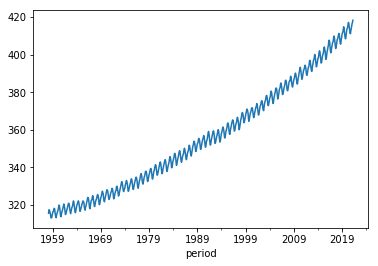

In [21]:
data_valuesonly['CO2'].plot()

## La contribution périodique  
On remarque une évolution périodique, due à des variations saisonnières, superposées à une variation continue et plus lente. On veut maintenant caractériser l'évolution périodique

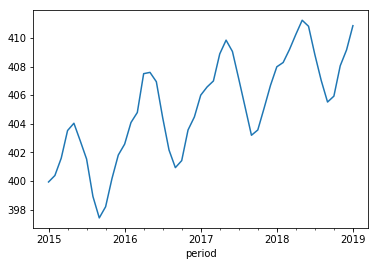

In [22]:
data_valuesonly['CO2']['2015-01':'2019-01'].plot()


## La contribution lente  
On veut extraire la contribution lente et l'extrapoler à 2025. Une première approche est une évolution linéaire à partir de 1958.

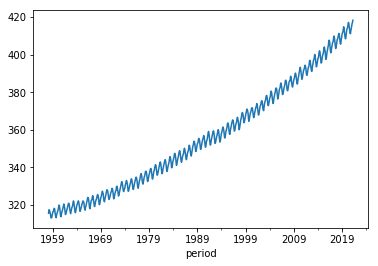

In [10]:
data_valuesonly['CO2'].plot()

In [23]:
import statsmodels.api as sm

data_valuesonly["Intercept"]=1
logmodel=sm.GLM(data_valuesonly['CO2'], data_valuesonly[['Intercept','index']]).fit()
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  753
Model:                            GLM   Df Residuals:                      751
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          20.521
Method:                          IRLS   Log-Likelihood:                -2205.0
Date:                Fri, 11 Jun 2021   Deviance:                       15412.
Time:                        15:22:50   Pearson chi2:                 1.54e+04
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    305.3562      0.334    913.159      0.000     304.701     306.012
index          0.1326      0.001    174.904      0.000       0.131       0.134
==============================================================================
"""

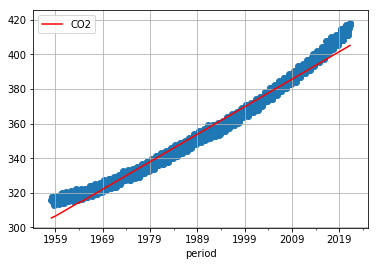

In [19]:
data_pred = pd.DataFrame({'index': np.linspace(1,len(data_valuesonly['CO2']), len(data_valuesonly['CO2'])),
                          'Intercept': 1})
data_pred['CO2'] = logmodel.predict(data_pred[['Intercept','index']])
data_pred['period'] = data_valuesonly.index
data_pred.plot(x="period",y="CO2",kind='line',color='r')
plt.scatter(x=data_valuesonly.index,y = data_valuesonly["CO2"])
plt.grid(True)

Avec cette prédiction, la teneur en CO2 dans l'atmosphère en avril 2025 serait de $412\ ppm$. On reste donc en dessous des dernières valeurs atteintes. Pour être plus réalistes, on veut maintenant estimer la teneur en CO2 avec une approximation linéaire à partir de l'an 2000 (index 505 pour le mois de Janvier 2000) au vue de la croissance plus rapide sur les dernières années:

In [31]:
logmodel=sm.GLM(data_valuesonly['CO2'][505:], data_valuesonly[['Intercept','index']][505:]).fit()
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  248
Model:                            GLM   Df Residuals:                      246
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          5.4151
Method:                          IRLS   Log-Likelihood:                -560.35
Date:                Fri, 11 Jun 2021   Deviance:                       1332.1
Time:                        15:34:11   Pearson chi2:                 1.33e+03
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    272.7958      1.322    206.343      0.000     270.205     275.387
index          0.1866      0.002     90.406      0.000       0.183       0.191
==============================================================================
"""

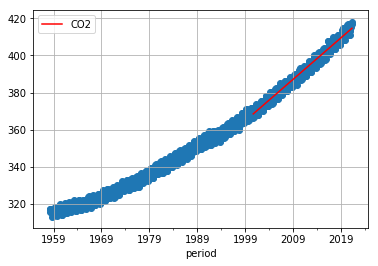

In [30]:
data_pred = pd.DataFrame({'index': data_valuesonly['index'][505:],
                          'Intercept': 1})
data_pred['CO2'] = logmodel.predict(data_pred[['Intercept','index']])
data_pred['period'] = data_valuesonly.index[505:]
data_pred.plot(x="period",y="CO2",kind='line',color='r')
plt.scatter(x=data_valuesonly.index,y = data_valuesonly["CO2"])
plt.grid(True)

Cette fois, la teneur en CO2 en avril 2025 est estimée à $422\ ppm$.  